In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c + (x/b)**(-a)


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 90.24it/s]


loss 0.007633970780512636
y = 8.77e+00 / (1 + x/2.57e-03)^-2.62e-01


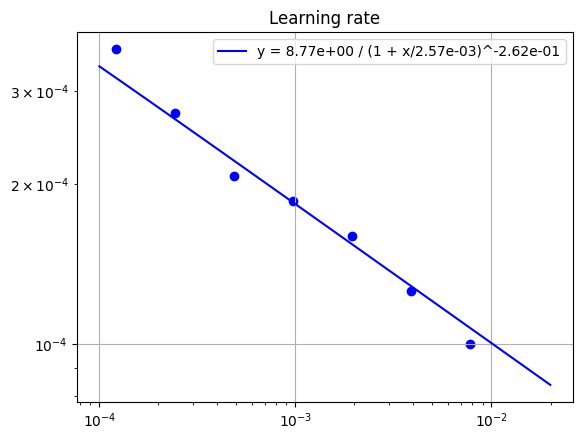

In [8]:
# large-batch training - fit() - uncertainty-corrected

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4, 3.7e-4])
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 1.86e-4, 2.07e-4, 2.73e-4, 3.6e-4]) # uncertainty corrected
fit_data_points = [3, 4, 5, 6]
plot_data_points = [1, 2, 3, 4, 5, 6, 7]
tried_values = [[4e-5], [1e-4, 2e-4], [1.26e-4, 1e-4, 2e-4], [1.6e-4, 1e-4, 2e-4], [2e-4, 1e-4], [2e-4, 2.5e-4, 3.2e-4], [2.5e-4, 2e-4], [3.2e-4, 2.7e-4, 3.7e-4]]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

# for i, lr_tried in enumerate(tried_values):
#     if i in plot_data_points:
#         plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')    
plt.title('Learning rate')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 104.89it/s]


loss 0.0025927195200633993



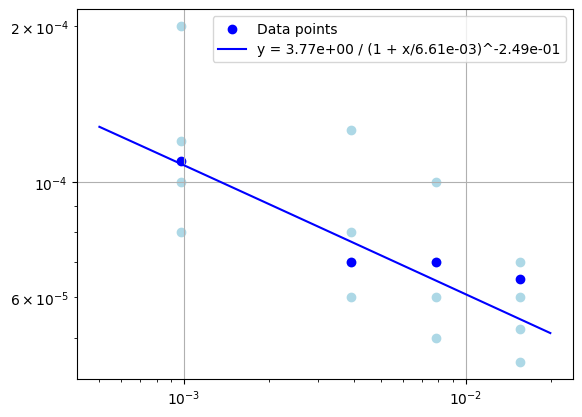

In [8]:
# Pushing, 2x width - fit


n_parallel = np.array([512, 1024, 2048, 8192])
utd = 1/n_parallel * 8
learning_rate = np.array([6e-5, 7e-5, 7e-5, 1e-4])
learning_rate = np.array([6.5e-5, 7e-5, 7e-5, 1.1e-4]) # uncertainty corrected
fit_data_points = [1, 2, 3]
plot_data_points = [0, 1, 2, 3]
lr_tried_values = [[6e-5, 7e-5], [5e-5, 1e-4], [6e-5, 1.26e-4], [1e-4, 2e-4]]
lr_tried_values = [[5.2e-5, 4.5e-5, 6e-5, 7e-5], [5e-5, 6e-5, 7e-5, 1e-4], [6e-5, 7e-5, 8e-5, 1.26e-4], [1.2e-4, 8e-5, 1e-4, 2e-4]] # values to try

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-0.3, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

for i, lr_tried in enumerate(lr_tried_values):
    plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=256: {get_lr(256):.2e}')
print(f'Predicted learning rate for n_parallel=512: {get_lr(512):.2e}')
print(f'Predicted learning rate for n_parallel=1024: {get_lr(1024):.2e}')
print(f'Predicted learning rate for n_parallel=2048: {get_lr(2048):.2e}')
print(f'Predicted learning rate for n_parallel=4096: {get_lr(4096):.2e}')
print(f'Predicted learning rate for n_parallel=8192: {get_lr(8192):.2e}')


Predicted learning rate for n_parallel=256: 4.49e-05
Predicted learning rate for n_parallel=512: 5.24e-05
Predicted learning rate for n_parallel=1024: 6.12e-05
Predicted learning rate for n_parallel=2048: 7.14e-05
Predicted learning rate for n_parallel=4096: 8.33e-05
Predicted learning rate for n_parallel=8192: 9.73e-05


27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


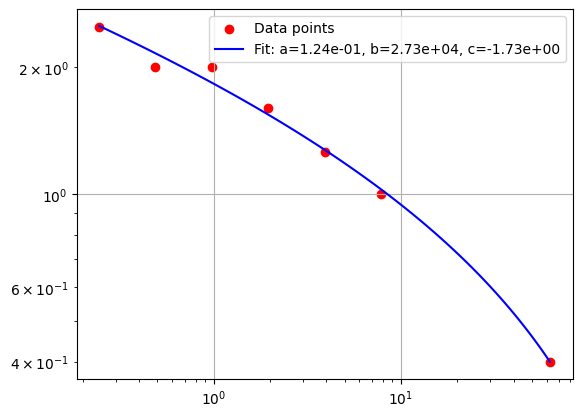

In [14]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


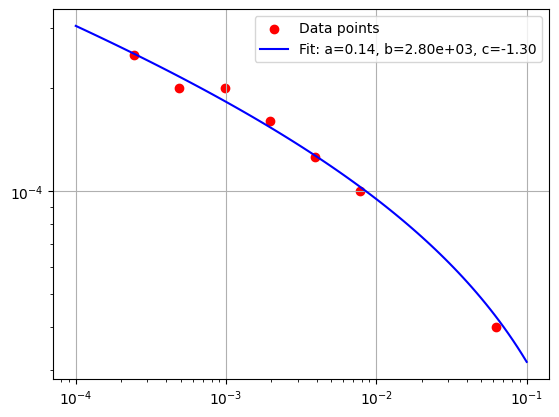

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/sit

loss 0.41987349469597063
y = 2.00e+00 / (1 + x/1.09e-05)^-8.00e-01


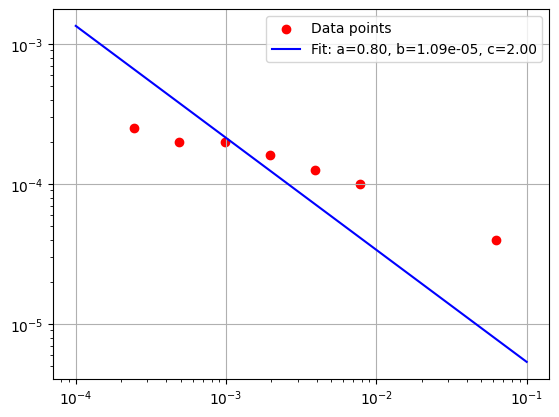

In [30]:
# large-batch training - log space - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((log_lr_rule(x,a,b,c) - np.log(y)) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def log_lr_rule(x, a, b, c):
    return np.log(c) - a * np.log(1 + x/b)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = np.exp(log_lr_rule(x_smooth, a, b, c))

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()